In [1]:
%matplotlib inline
#matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context("talk")

# Keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Scikit Learn
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import confusion_matrix

# others
import pandas as pd
import numpy as np
import pickle as pkl
import uuid

Using TensorFlow backend.
/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

In [ ]:
data = pkl.load(open('data_norm_social.pickle', 'rb'))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    im = ax.matshow(cm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           #yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, 
           #yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i , format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.set_yticklabels([''] + classes)

    return ax


In [ ]:
"""
Classes for performing the NN training.
"""

import warnings
warnings.filterwarnings('always')

def sp(y_true, y_pred, cut=0.):
    false_output_idx = np.where(y_pred < cut)
    output= np.ones(y_pred.shape)
    output[false_output_idx] = -1
    output = output.T[0]
    cm_ = confusion_matrix(y_true, output)
    cm_ = cm_.astype('float') / cm_.sum(axis=1)[:, np.newaxis]
    if cm_.shape[0] != 1:
        no_class_prob, class_prob = cm_.diagonal()
    else:
        # For the leaveOneOut case
        no_class_prob, class_prob = cm_[0], cm_[0]
    geometric_mean = np.sqrt(no_class_prob * class_prob)
    mean = np.mean([no_class_prob, class_prob])
    SP = np.sqrt(geometric_mean * mean)
    return SP


def sp_max(y_true, y_pred):
    cuts = np.arange(-1., 1., .05)
    sps = [sp(y_true, y_pred, cut)
           for cut in cuts]
    sp_max = np.max(sps)
    sp_max_cut = np.argmax(sps)
    return  sp_max, cuts[sp_max_cut]

In [ ]:
def oversample(data):
    count_class_0, count_class_1 = data['output'].value_counts()
    class_0 = data['output'].loc[data['output'] == 1]
    class_1 = data['output'].loc[data['output'] == -1]
    class_1_over = class_1.sample(count_class_0, replace=True)
    output = pd.concat([class_0, class_1_over], axis=0)
    normalized = data['normalized'].loc[output.index.tolist()]
    return normalized, output


def xval_generator_oversampling(data, k_folds=10):
    """Generator for X-Validation using K-folds approach"""

    X, y = oversample(data)

    skf = StratifiedKFold(n_splits=k_folds)
    X = X.values.astype('float32')
    y = y.values.astype('float32')
    # Oversampling
    

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        yield X_train, X_test, y_train, y_test

        
def get_model(n_neurons, input_shape):
    # model template
    model = Sequential()

    model.add(Dense(n_neurons,
                    activation='tanh',
                    input_shape=(input_shape,)))
    model.add(Dense(1,
                    activation='tanh',
                    input_shape=(n_neurons,)))
    return model

In [ ]:
def load_model(n_neurons, input_shape,ck_filepath):
    model = get_model(n_neurons, input_shape)
    model.load_weights(ck_filepath)  
    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])   
    return model

In [ ]:
def run_generator(data, k_folds=10, trials=10, n_neurons=10):
    for neurons in range(1, n_neurons + 1):
        for X_train, X_test, y_train, y_test in xval_generator_oversampling(data, k_folds):
            input_shape = X_train.shape[1]
            for trial in range(trials):
                yield(X_train, X_test, y_train, y_test, neurons, input_shape, trial)

In [ ]:
total_interations = sum(1 for _ in run_generator(data))
print(total_interations)

In [62]:
class ModelSPCheckPoint(ModelCheckpoint):
    """
    Expand model checkpoing callback for calculating best SP
    for the best network setup.
    """
    
    def __init__(self, filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1, **kwargs):
        """"""
        super(ModelSPCheckPoint, self).__init__(filepath,
                                                monitor,
                                                verbose,
                                                save_best_only,
                                                save_weights_only,
                                                mode,
                                                period)
        self.best_sp = -np.inf
        self.best_sp_train = -np.inf
        self.cut = 0.
        self.x_train = kwargs.get('x_train')
        self.y_train = kwargs.get('y_train')
        
    def on_epoch_end(self, epoch, logs={}):
        """
        """
        super(ModelSPCheckPoint, self).on_epoch_end(epoch, logs)

        if self.save_best_only:
            current = logs.get(self.monitor)
            if current == self.best:
                # Compute SP for train data and retrieve best cut
                y_train_pred = self.model.predict(self.x_train)
                sp_train, cut = sp_max(self.y_train, y_train_pred)
                self.best_sp_train = sp_train
                self.cut = cut
                # Compute SP for validation data
                y_pred = self.model.predict(self.validation_data[0])
                y_true = self.validation_data[1]
                self.best_sp = sp(y_true, y_pred, cut=cut)

In [63]:
def run_mlp(X_train, X_test, y_train, y_test,
            n_neurons, input_shape, trial):
    epochs = 1000
    batch_size = 10
    mid =  str(uuid.uuid4())
    model = get_model(n_neurons, input_shape)
    model.compile(loss='mean_squared_error',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    result_id = '%s.%02d.%04d' % (mid, n_neurons, trial)
    filepath = ".networks/%s.hdf5" % (result_id)
    pklpath = ".networks/%s.p" % (result_id)

    checkpoint = ModelSPCheckPoint(filepath,
                                   monitor='val_loss',
                                   verbose=False,
                                   save_weights_only=True,
                                   save_best_only=True,
                                   mode='min',
                                   x_train=X_train,
                                   y_train=y_train)
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        verbose=False,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpoint])


    checkpoint_file = filepath
    results =  {'id': result_id,
                'cut': checkpoint.cut,
                'val_loss_history': history.history['val_loss'],
                'loss_history': history.history['loss'],
                'n_neurons': n_neurons,
                'checkpoint_file': filepath,
                'sp': checkpoint.best_sp,
                'sp_train': checkpoint.best_sp_train} 
    with open(pklpath, 'wb') as pklfile:
        pkl.dump(results, pklfile, protocol=pkl.HIGHEST_PROTOCOL)
    return (n_neurons, result_id)

In [64]:
from joblib import Parallel, delayed
from tqdm import tqdm_notebook


results = []

with Parallel(n_jobs=-1) as parallel:
     results = parallel(delayed(run_mlp)(X_train, X_test, y_train, y_test, n_neurons, input_shape, trial) 
                        for X_train, X_test, y_train, y_test, n_neurons, input_shape, trial
                        in tqdm_notebook(run_generator(data), total=total_interations))




In [65]:
results = pd.DataFrame(results, columns=['n_neurons', 'id'])
results.to_csv('.networks/results_all_oversampling.csv')

In [66]:
summary = []
for group_id, group in results.groupby('n_neurons'):
    n_neurons = group.n_neurons.unique()[0]
    for idx in group.id:
        pklpath = f'.networks/{idx}.p'
        with open(pklpath, 'rb') as pklfile:
            res = pkl.load(pklfile)
            summary.append({ 'n_neurons': n_neurons,
                             'id': idx,
                             'sp': res['sp'],
                             'sp_train': res['sp_train']})
summary = pd.DataFrame.from_records(summary)

/Users/fguimara/.pyenv/versions/3.7.2/envs/pleuraltb/lib/python3.7/site-packages/pandas/plotting/_core.py:2254: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


Text(0.5, 0.98, '')

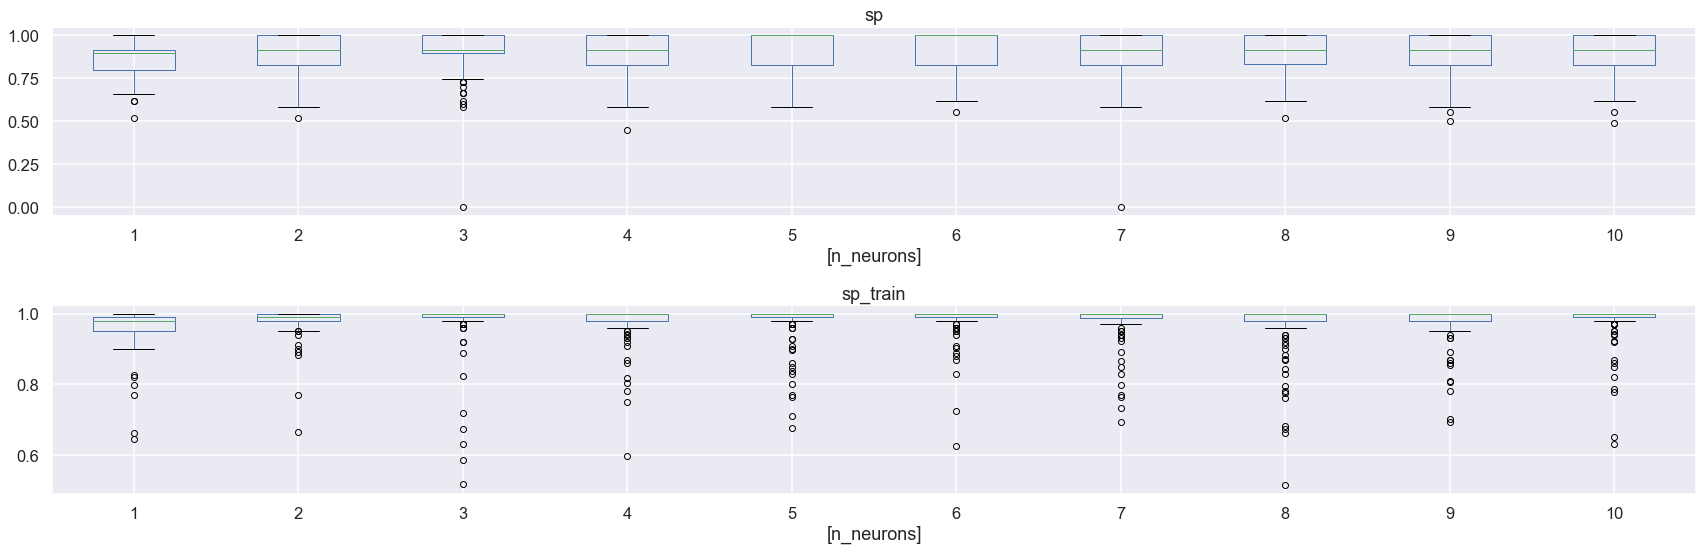

In [67]:
fig, axes = plt.subplots(2, 1, figsize=(24, 8))
summary.boxplot(by='n_neurons', ax=axes)
fig.tight_layout()
fig.suptitle('')

In [69]:
summary[(summary['n_neurons']==4) & (summary['sp']> 0.9)] 

id  n_neurons        sp  \
303  4ddef584-493b-4eb2-9488-942e092d1589.04.0003          4  0.914767   
313  737b0830-7d0e-4d1e-9a44-a5904bdd024a.04.0003          4  0.914767   
314  bf4b7264-c356-46fa-a2be-07f8c25e071a.04.0004          4  0.914767   
315  cd32dba6-38a8-4ff1-889e-56c4fbf6df4b.04.0005          4  0.914767   
317  1eb86b99-aee1-45cd-926d-f14eabaf14d1.04.0007          4  0.914767   
320  8c77adc4-80a1-4deb-9cc5-b31d94abe946.04.0000          4  0.914767   
322  70b215f9-6a8d-49eb-86e5-8f8959090c62.04.0002          4  0.914767   
323  6d2a1df3-a550-4a89-9900-f505536963d0.04.0003          4  1.000000   
328  5204767c-0fdb-42df-ade1-69cb691ec258.04.0008          4  0.914767   
330  ac313962-a78d-4a99-a9c7-42dca9a58b37.04.0000          4  0.914767   
331  a89ece70-dd42-4c2b-bde0-e391db5f7704.04.0001          4  0.914767   
332  43cab738-3de1-413d-8445-236b249485f7.04.0002          4  1.000000   
334  ea418e33-5890-4497-b2b4-68db3a0f6a0f.04.0004          4  0.914767   
335  0bb9da86-ba5d-4aa7-8fb5-bc19b8ca7cc9.04.0005          4  0.914767   
336  281526c4-1cfb-4984-bca6-c3dae9af0e4b.04.0006          4  0.914767   
337  479b11da-f00e-4970-961d-83d8a61099db.04.0007          4  0.914767   
338  c76ad543-c5ec-427f-aa2e-53dfd34c9618.04.0008          4  0.914767   
340  fb9ef611-ef10-4e49-8e2e-7fad08b4a254.04.0000          4  0.914767   
341  48abe3b9-ffe0-47ab-8920-52682c803ab2.04.0001          4  1.000000   
348  f57788be-a1bf-4989-9f49-9494b9370e7a.04.0008          4  0.914767   
349  6e81628b-5b68-46c0-a02c-9cb531efcd6a.04.0009          4  1.000000   
350  3874eabc-331d-43fd-ac3f-82252107e30d.04.0000          4  0.914767   
351  0ce6fd24-8e7b-4a3d-8fe5-b2325791707e.04.0001          4  1.000000   
352  8db74f20-3698-4ad6-a50b-ec1ccb0cb00f.04.0002          4  0.914767   
353  8e2b218e-2ff0-422b-a113-791d1162108a.04.0003          4  0.914767   
354  5aa5f5eb-e768-47bd-aed5-2fe0fa69b690.04.0004          4  1.000000   
355  47581133-4a45-4a07-b7d4-21fe0df02763.04.0005          4  1.000000   
356  b6219b5b-41df-40cb-ba9f-7a300ea30dca.04.0006          4  1.000000   
357  b15a78f4-78c6-41f5-8abb-fbe80ad53295.04.0007          4  1.000000   
358  eaf72917-3283-459a-8fdb-0097addd37c0.04.0008          4  1.000000   
359  4a3e9b17-e936-4e50-b285-3d842598fd7f.04.0009          4  1.000000   
360  bfd8e1e5-034b-47e8-841a-a0a0831129e8.04.0000          4  1.000000   
361  cb5450f9-dfcd-40af-b5f0-8c9a53fb7f36.04.0001          4  1.000000   
366  545dc48e-24e9-4d71-97eb-73b65c071d08.04.0006          4  1.000000   
367  d331edc4-9a22-440c-931f-171472616c98.04.0007          4  1.000000   
368  47a99407-91b1-4d67-9ce6-23403da81498.04.0008          4  1.000000   
370  ca8b3a20-1f05-49a0-9344-e4857267228b.04.0000          4  1.000000   
371  19209d27-95b3-4dca-9369-7ca8d526da94.04.0001          4  1.000000   
372  3fce67ff-dd21-46a6-a03f-22183de28ef5.04.0002          4  1.000000   
373  940b6c6a-ec39-4ac8-926d-70969e079d81.04.0003          4  1.000000   
374  ac452c1f-3e11-49d7-94d3-e1dccba4fb4d.04.0004          4  1.000000   
375  bb89d597-7440-4b36-9dba-f5b75229eb32.04.0005          4  1.000000   
376  539ca9cd-95da-4d56-a0c1-5eda6fac49bd.04.0006          4  1.000000   
377  094ff87f-4fc4-45ac-a5f9-24fa64b46de1.04.0007          4  1.000000   
378  10017ea1-05ea-4725-b6d1-dbb12f72d7b8.04.0008          4  1.000000   
379  1e19a4c6-e74f-4b63-ae14-f75a03aff939.04.0009          4  1.000000   
381  1020df33-a395-4636-ba80-951eefd9fdcb.04.0001          4  1.000000   
383  da923ff2-93df-4485-9503-fde939ec13d8.04.0003          4  1.000000   
384  af0f1f7f-5827-42ba-8603-d4d2862b37ff.04.0004          4  1.000000   
385  f6158571-7d7b-4beb-8736-40f9ff3094aa.04.0005          4  1.000000   
386  3b797143-fa9a-4491-8f75-383d47df20cf.04.0006          4  1.000000   
387  9355c729-c227-4679-831b-ca478dfea108.04.0007          4  1.000000   
389  733a2309-4f31-49c0-bb4f-011ec62ff663.04.0009          4  1.000000   

     sp_train  
303  0.989975  
313  1.000000  
31

In [78]:
filepath = ".networks/3874eabc-331d-43fd-ac3f-82252107e30d.04.0000"
best_model  = load_model(4, 87, filepath + '.hdf5')
with open(filepath + ".p", "rb") as pfile:
    res = pkl.load(pfile)

Confusion matrix, without normalization


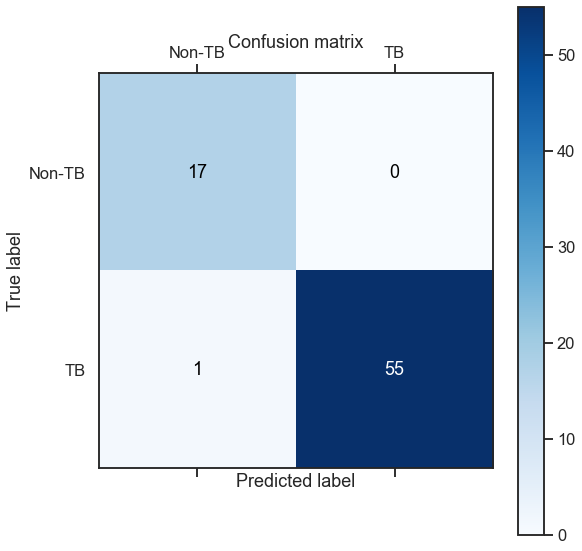

In [79]:
import itertools
import numpy as np
y_pred_out = best_model.predict(data['normalized'].values).reshape(-1)
y_pred = 2 * (y_pred_out > res['cut']) - 1
y_test = data['output'].values


with sns.axes_style('white'):
    sns.set_context("talk")
    ax = plot_confusion_matrix(y_test, y_pred, classes=['Non-TB', 'TB'],
                               title='Confusion matrix')


Text(0.5, 1.0, 'Saída para os dados')

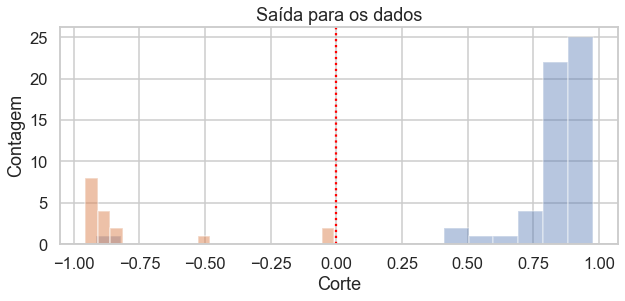

In [80]:
sns.set_context('talk')
sns.set_style('whitegrid')


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(y_pred_out[np.where(y_test > res['cut'])[0]], alpha=.4, bins=20)
ax.hist(y_pred_out[np.where(y_test < res['cut'])[0]], alpha=.5, bins=20)
ax.axvline(res['cut'], linestyle=':', color='red')
ax.set_xlabel('Corte')
ax.set_ylabel('Contagem')

ax.set_title('Saída para os dados')

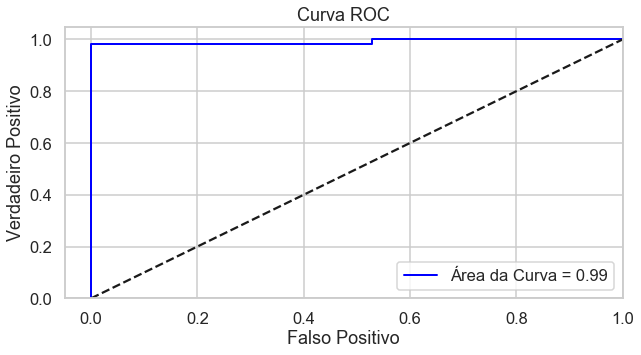

In [81]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_pred_out, drop_intermediate=False)
roc_auc = auc(fpr, tpr)
sns.set_context('talk')
sns.set_style('whitegrid')


fig, ax = plt.subplots(1,1, figsize=(10, 5))
lw = 2

ax.plot(fpr, tpr, color='blue',
         lw=lw, label='Área da Curva = %0.2f' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Falso Positivo')
ax.set_ylabel('Verdadeiro Positivo')
ax.set_title('Curva ROC')
plt.legend(loc="lower right")
